### Adicionando dependencias

In [1]:
import nltk.translate.bleu_score as bleu
import nltk.translate.gleu_score as gleu
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LinearRegression

import seaborn as sns
import pandas as pd

%matplotlib inline
sns.set()

### Adicionando função para avaliar o wer_score

In [2]:
def wer_score(hyp, ref, print_matrix=False):
  N = len(hyp)
  M = len(ref)
  L = np.zeros((N,M))
  for i in range(0, N):
    for j in range(0, M):
      if min(i,j) == 0:
        L[i,j] = max(i,j)
      else:
        deletion = L[i-1,j] + 1
        insertion = L[i,j-1] + 1
        sub = 1 if hyp[i] != ref[j] else 0
        substitution = L[i-1,j-1] + sub
        L[i,j] = min(deletion, min(insertion, substitution))
        # print("{} - {}: del {} ins {} sub {} s {}".format(hyp[i], ref[j], deletion, insertion, substitution, sub))
  if print_matrix:
    print("WER matrix ({}x{}): ".format(N, M))
    print(L)
  return int(L[N-1, M-1])

### Lendo os resultados

In [3]:
def read_json(filepath):
    file = open(filepath, 'r')
    aux_base = json.load(file)
    keys = aux_base[0].keys()
    for i, key in enumerate(keys):
        if i == 0:
            temp = []
            for j in range(len(aux_base)):
                temp.append(aux_base[j][key])
            base = pd.DataFrame({key: temp})
        else:
            temp = []
            for j in range(len(aux_base)):
                temp.append(aux_base[j][key])
            base[key] = temp
    return add_from_to_codelang(base)

In [40]:
def add_from_to_codelang(data):
    codes = []
    langs = []
    for i in range(len(data)): 
        codes.append(data['To'][i])
        langs.append(data['Language'][i])
    from_codes = []
    from_langs = []
    for i in range(len(codes)-1):
        from_codes.append(codes[i])
        from_langs.append(langs[i])
    from_codes.insert(0, None)
    data['From code'] = from_codes
    from_langs.insert(0,None)
    data['From lang'] = from_langs
    data.rename(columns = {'Language': 'To lang', 'Code': 'To code'}, inplace = True)
    return data

In [41]:
base_very_high = read_json('results/idh_very_high_2019_09_12_monit.json')
base_high = read_json('results/idh_high_2019_09_12_monit.json')
base_medium = read_json('results/idh_medium_2019_09_12_monit.json')
base_low = read_json('results/idh_low_2019_09_12_monit.json')
base_all = read_json('results/idh_2019_09_12_monit.json')

### Adicionando funções para visualizar resultados

In [43]:
def plotData(history, title, ax, log = False, x = None, size = None,
             regression = False, ylabel = 'Pontuação', xlabel = True,
             smog_hists = None, linewidth = 3.5):
    if smog_hists is not None:
        ys = smog_hists
        xs = []
        for y_ in ys:
            sz = len(y_)
            xs.append(np.arange(sz))
        for i in range(len(ys)):
            y_, x_ = [ys[i], xs[i]]
            ax.plot(x_, y_, linewidth = 1, color = 'grey', alpha = 0.6)
    sz = size
    if sz is None:
        sz = len(history)
    #ax.figure(figsize = (13,7))
    
    y = history[0:sz]
    if log:
        y = -np.log(y)
    if x is None:
        x = np.arange(0, len(y))
    if regression:
        y_temp = y.reshape(-1,1)
        x_temp = x.reshape(-1,1)
        reg = LinearRegression()
        reg.fit(x_temp, y_temp)
        lin_x = np.linspace(0,sz-1).reshape(-1,1)
        lin_y = reg.predict(lin_x)
        ax.plot(lin_x, lin_y, '--', linewidth = 1, color = 'purple')
    ax.plot(x, y, marker = '^', markerfacecolor = 'purple',
             linewidth = linewidth, markersize = 4, color = 'coral')
    ax.set_title(title)
    if xlabel:
        ax.set_xlabel('Iterações')
    if log:
        ax.set_ylabel(['-log[',ylabel,']'])
    else:
        ax.set_ylabel(ylabel)
    #plt.grid()
    #ax.show()

In [44]:
def plotData2(ys, title, legends = None, ylabel = 'Pontuação'):
    xs = []
    for y in ys:
        size = len(y)
        xs.append(np.arange(size))
    for i in range(len(ys)):
        y, x = [ys[i], xs[i]]
        plt.plot(x, y, linewidth = 2)
    plt.ylabel(ylabel)
    plt.xlabel('Iterações')
    plt.title(title)
    if legends is not None:
        plt.legend(legends)

In [45]:
def plotData3(y, title, legends = None, ylabel = 'Pontuação', linewidth = 3.5):
    x = np.arange(len(y))
    plt.plot(x, y, marker = '^', markerfacecolor = 'purple', linewidth = linewidth, markersize = 4, color = 'coral')
    plt.ylabel(ylabel)
    plt.xlabel('Iterações')
    plt.title(title)
    if legends is not None:
        plt.legend(legends)

### Visualização do acumulado

In [46]:
def accHistory(data, kind = 'GLEU'):
    size = len(data)
    hist = []
    reference = data['Text_en'][0]
    
    for i in range(size):
        hypothesis = data['Text_en'][i]
        if kind == 'GLEU':
            hist.append(gleu.sentence_gleu([reference], hypothesis))
        elif kind == 'BLEU':
            hist.append(bleu.sentence_bleu([reference], hypothesis))
        elif kind == 'WER':
            hist.append(wer_score(hypothesis.split(), reference.split(), print_matrix = False))
        else:
            print('ERRO: Kind not valid!')
            return -1
    return np.asarray(hist)

In [47]:
base_very_high['GLEU acc'] = accHistory(base_very_high, 'GLEU')
base_high['GLEU acc'] = accHistory(base_high, 'GLEU')
base_medium['GLEU acc'] = accHistory(base_medium, 'GLEU')
base_low['GLEU acc'] = accHistory(base_low, 'GLEU')
base_all['GLEU acc'] = accHistory(base_all, 'GLEU')

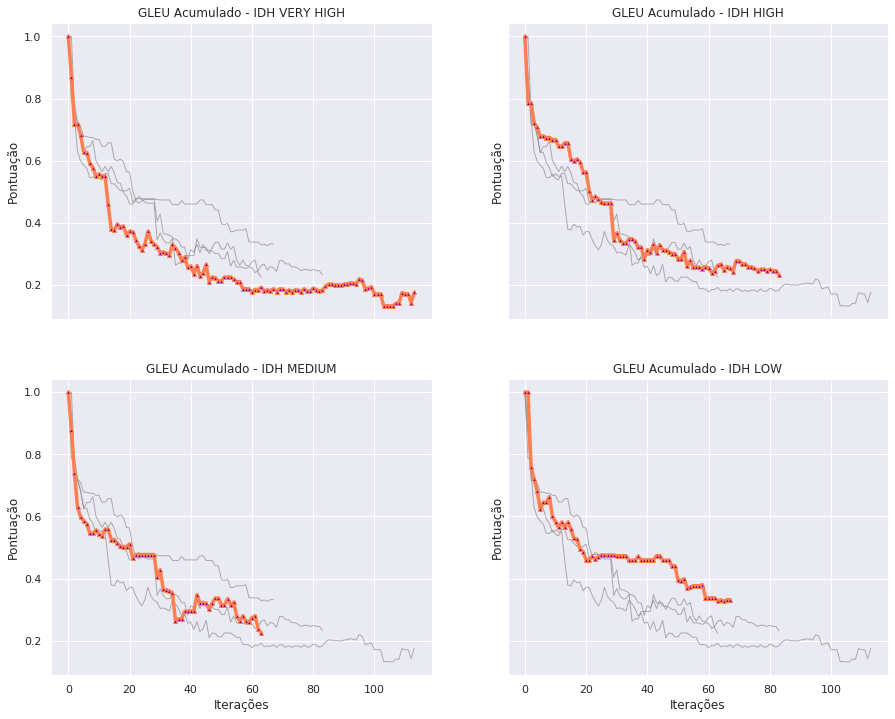

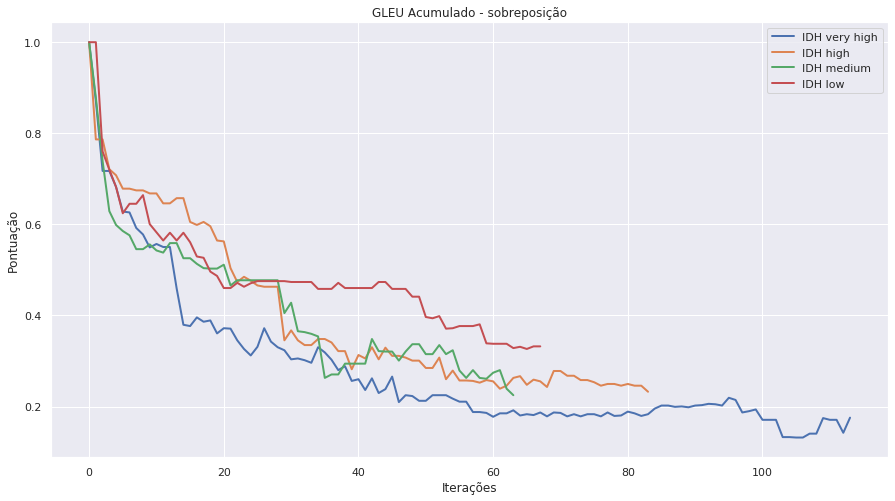

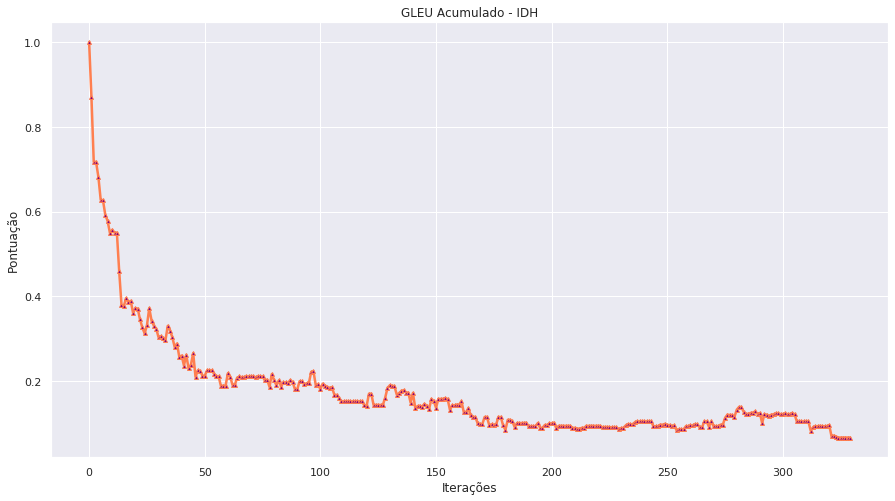

In [48]:
histories = [base_very_high['GLEU acc'], base_high['GLEU acc'],
             base_medium['GLEU acc'], base_low['GLEU acc']]
f, axs = plt.subplots(2, 2, sharey = True, sharex = True, figsize=(15,12))
plotData(base_very_high['GLEU acc'], 'GLEU Acumulado - IDH VERY HIGH', axs[0,0],
         xlabel = False, smog_hists = histories)
plotData(base_high['GLEU acc'], 'GLEU Acumulado - IDH HIGH', axs[0,1],
         xlabel = False, smog_hists = histories)
plotData(base_medium['GLEU acc'], 'GLEU Acumulado - IDH MEDIUM', axs[1,0], xlabel = True,
         smog_hists = histories)
plotData(base_low['GLEU acc'], 'GLEU Acumulado - IDH LOW', axs[1,1], xlabel = True,
         smog_hists = histories)

plt.figure(figsize=(15,8))
plotData2(histories, 'GLEU Acumulado - sobreposição', legends = ['IDH very high', 'IDH high', 'IDH medium', 'IDH low'])
plt.figure(figsize=(15,8))
plotData3(base_all['GLEU acc'], 'GLEU Acumulado - IDH', linewidth = 2.5)

In [59]:
base_very_high['WER acc'] = accHistory(base_very_high, 'WER')
base_high['WER acc'] = accHistory(base_high, 'WER')
base_medium['WER acc'] = accHistory(base_medium, 'WER')
base_low['WER acc'] = accHistory(base_low, 'WER')
base_all['WER acc'] = accHistory(base_all, 'WER')

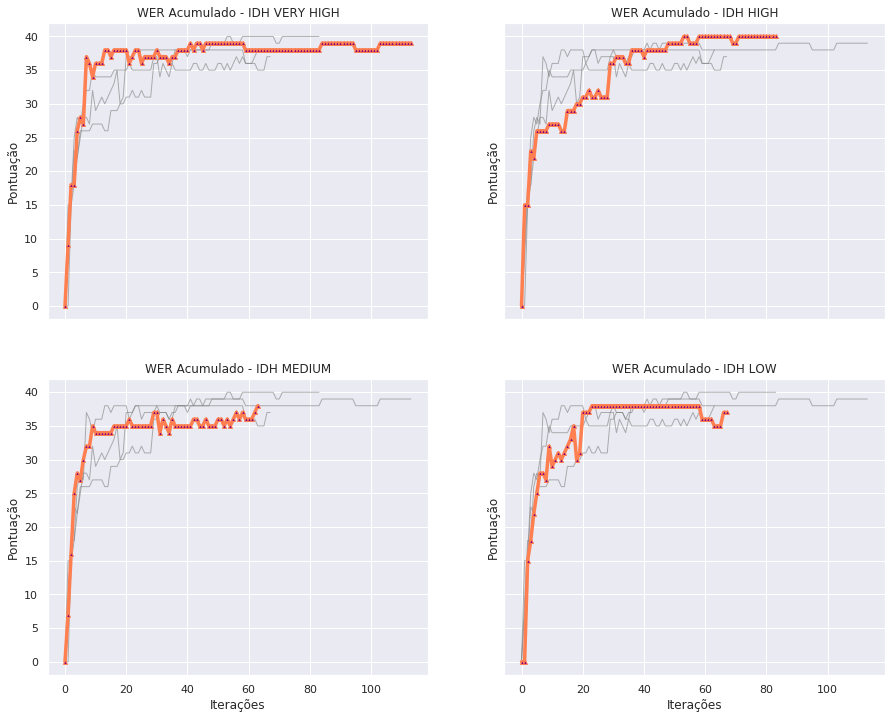

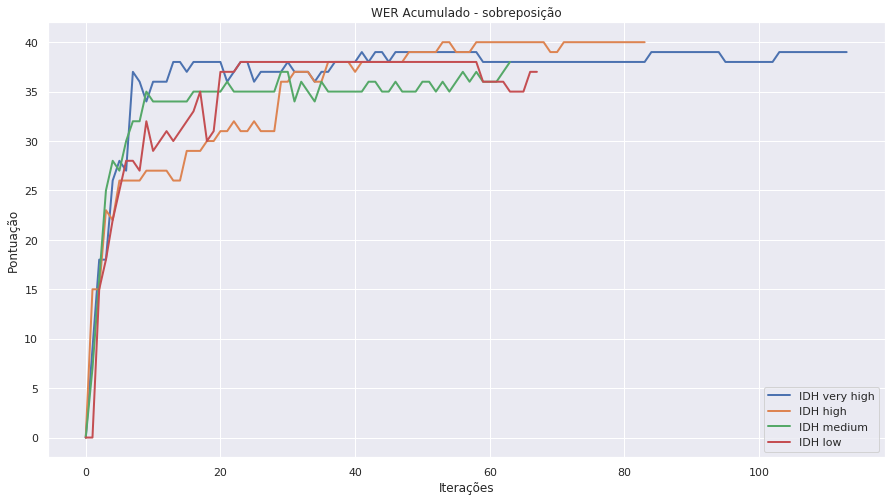

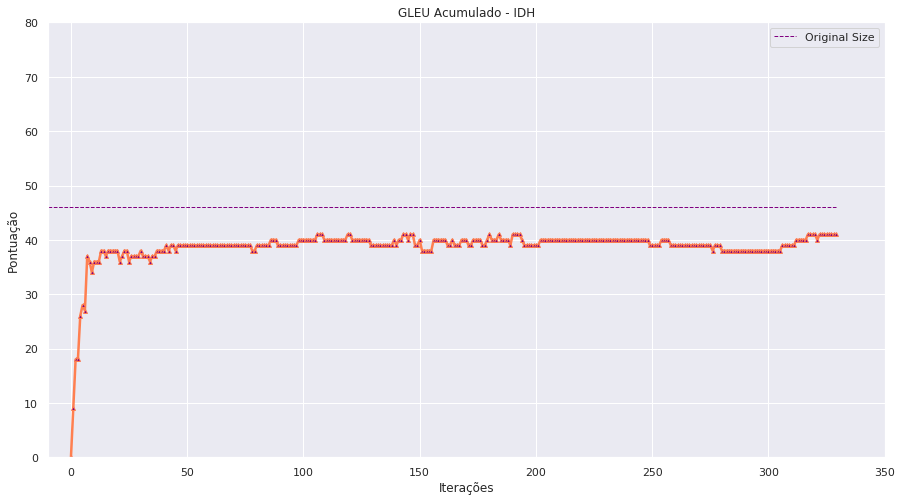

In [66]:
histories = [base_very_high['WER acc'], base_high['WER acc'],
             base_medium['WER acc'], base_low['WER acc']]

f, axs = plt.subplots(2, 2, sharey = True, sharex = True, figsize=(15,12))
plotData(base_very_high['WER acc'], 'WER Acumulado - IDH VERY HIGH', axs[0,0],
         xlabel = False, smog_hists = histories)
plotData(base_high['WER acc'], 'WER Acumulado - IDH HIGH', axs[0,1],
         xlabel = False, smog_hists = histories)
plotData(base_medium['WER acc'], 'WER Acumulado - IDH MEDIUM', axs[1,0], xlabel = True,
         smog_hists = histories)
plotData(base_low['WER acc'], 'WER Acumulado - IDH LOW', axs[1,1], xlabel = True,
         smog_hists = histories)

plt.figure(figsize=(15,8))
plotData2(histories, 'WER Acumulado - sobreposição', legends = ['IDH very high', 'IDH high', 'IDH medium', 'IDH low'])
plt.figure(figsize=(15,8))
plotData3(base_all['WER acc'], 'GLEU Acumulado - IDH', linewidth = 2.5)
ref_size = len(base_all['Text_origin'][0].split())
plt.plot(np.arange(-10,len(base_all['WER acc'])), ref_size*np.ones(len(base_all['WER acc'])+10), '--', color = 'purple',
         linewidth = 1, label='Original Size')
plt.axis([-10, 350, 0, 80])
plt.legend()

### Visualização do passo a passo

In [67]:
def papHistory(data, kind = 'GLEU'):
    size = len(data)
    if kind == 'GLEU' or kind == 'BLEU':
        hist = [1.0]
    else:
        hist = [0]
    j = 0
    for i in range(size-1):
        reference = data['Text_en'][i]
        hypothesis = data['Text_en'][i+1]
        score = 0
        if kind == 'GLEU':
            score = gleu.sentence_gleu([reference], hypothesis)
        elif kind == 'BLEU':
            score = bleu.sentence_bleu([reference], hypothesis)
        elif kind == 'WER':
            score = wer_score(hypothesis.split(), reference.split(), print_matrix = False)
        else:
            print('ERRO: Kind not valid!')
            return -1
        j += 1
        hist.append(score)
    return np.asarray(hist)

In [68]:
def findOutliers(data, hist, x = None, n = 5, kind = 'GLEU'):
    sz = len(hist)
    if x is None:
        x = np.arange(sz)
    pairs = []
    for i in range(sz):
        pairs.append([hist[i], x[i]])
    pairs.sort(key=lambda tup: tup[0])
    ansy = []
    ansx = []
    if kind == 'GLEU' or kind == 'BLEU':
        k = 0;
        for i in range(n):
            ansy.append(pairs[k][0])
            ansx.append(pairs[k][1])
            k += 1
    elif kind == 'WER':
        k = sz-1;
        for i in range(n):
            ansy.append(pairs[k][0])
            ansx.append(pairs[k][1])
            k -= 1
    else:
        print('ERRO: Kind not valid!')
        return -1
    legends = []
    for i in range(n):
        legends.append(data['To code'][ansx[i]-1]+' - '+data['To code'][ansx[i]])
    return np.asarray(ansx), np.asarray(ansy), legends

In [69]:
def plotData4(data, title, ax, name = 'GLEU pap', kind = 'GLEU', linewidth = 3):
    plotData(data[name], title, ax, xlabel = False, linewidth = linewidth)

    x, y, leg = findOutliers(data, data[name], kind = kind)
    leg.insert(0, 'history')
    for i in range(len(x)):
        ax.scatter(x[i], y[i], s = 100)
    ax.legend(leg)

In [70]:
base_very_high['GLEU pap'] = papHistory(base_very_high, 'GLEU')
base_high['GLEU pap'] = papHistory(base_high, 'GLEU')
base_medium['GLEU pap'] = papHistory(base_medium, 'GLEU')
base_low['GLEU pap'] = papHistory(base_low, 'GLEU')
base_all['GLEU pap'] = papHistory(base_all, 'GLEU')

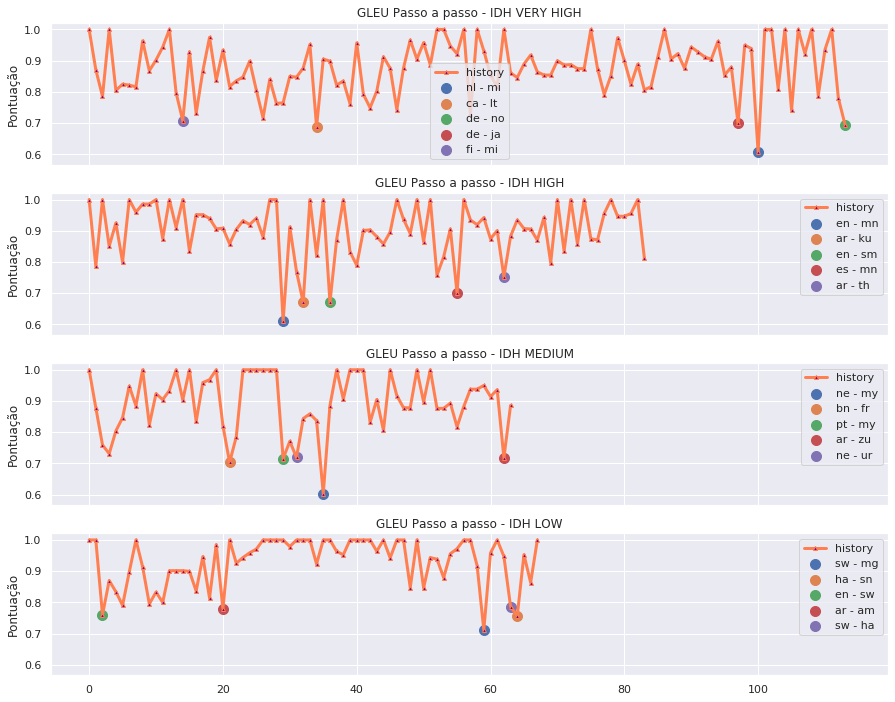

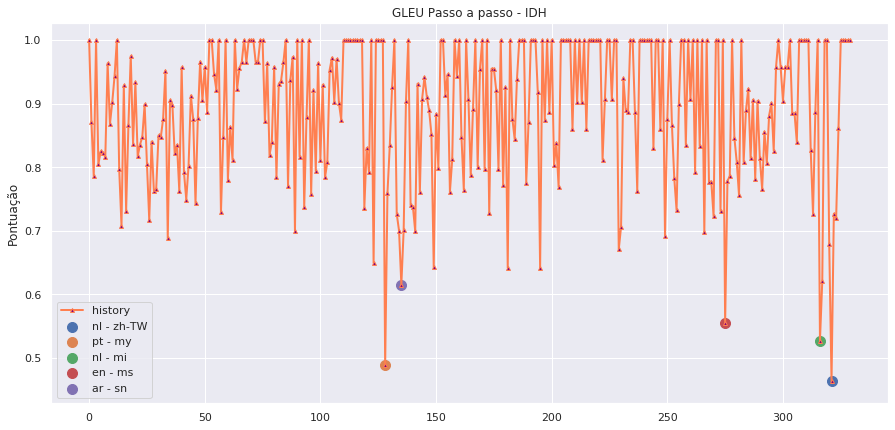

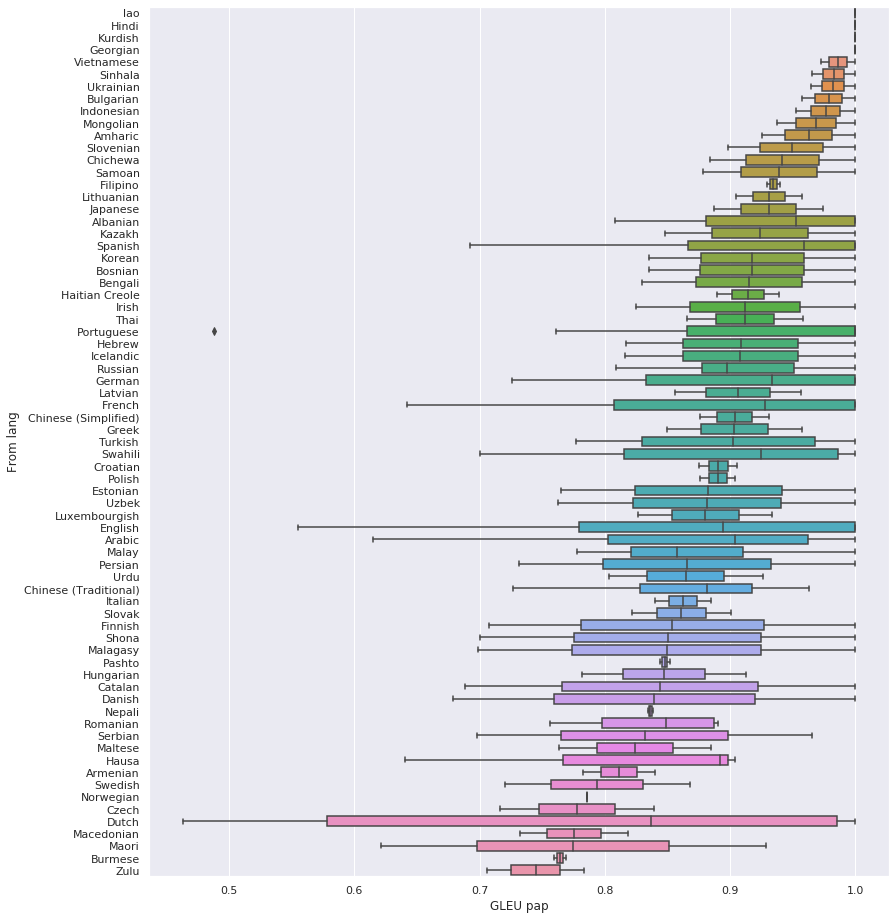

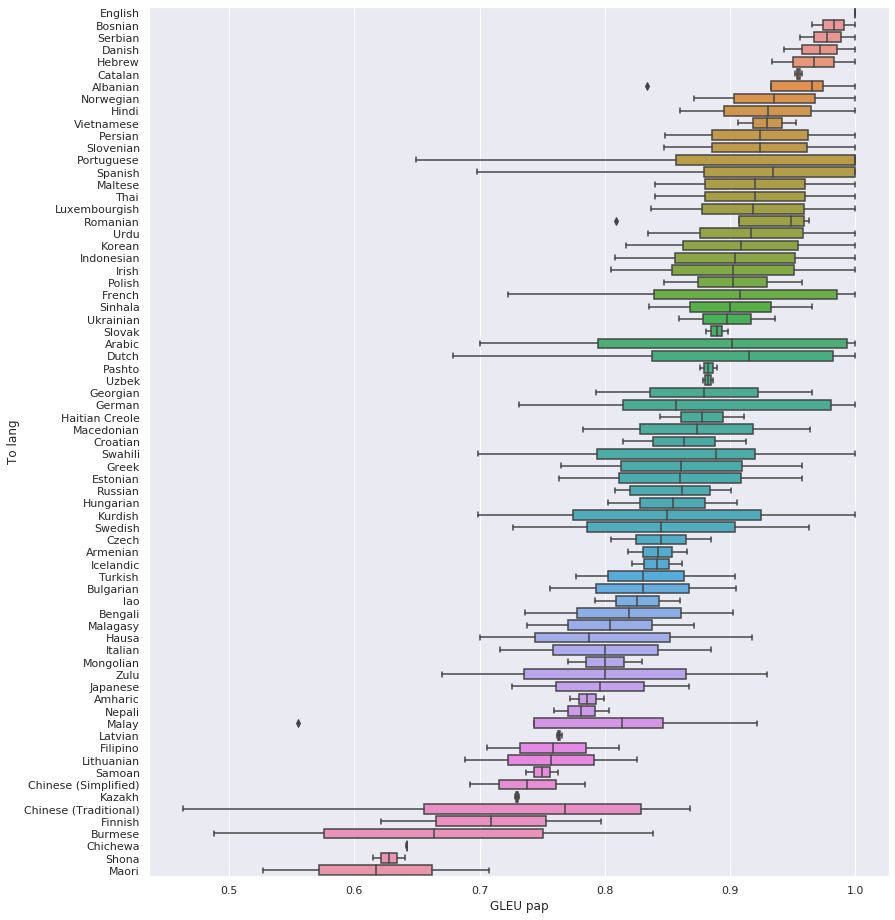

In [71]:
histories = [base_very_high['GLEU pap'], base_high['GLEU pap'],
             base_medium['GLEU pap'], base_low['GLEU pap']]

f, axs = plt.subplots(4, 1, sharey = True, sharex = True, figsize=(15,12))
plotData4(base_very_high, 'GLEU Passo a passo - IDH VERY HIGH', axs[0], name = 'GLEU pap')
plotData4(base_high, 'GLEU Passo a passo - IDH HIGH', axs[1], name = 'GLEU pap')
plotData4(base_medium, 'GLEU Passo a passo - IDH MEDIUM', axs[2], name = 'GLEU pap')
plotData4(base_low, 'GLEU Passo a passo - IDH LOW', axs[3], name = 'GLEU pap')

f, ax = plt.subplots(1, 1, sharey = True, sharex = True, figsize=(15,7))
plotData4(base_all, 'GLEU Passo a passo - IDH', ax, name = 'GLEU pap', kind = 'GLEU', linewidth = 2)

plt.figure(figsize=(13.25,16))
sns.set()
ranks = base_all.groupby('From lang')['GLEU pap'].mean().sort_values(ascending = True)[::-1].index
sns.boxplot(data = base_all, y = 'From lang', x = base_all['GLEU pap'], order = ranks)
plt.figure(figsize=(13.25,16))
sns.set()
ranks = base_all.groupby('To lang')['GLEU pap'].mean().sort_values(ascending = True)[::-1].index
sns.boxplot(data = base_all, y = 'To lang', x = base_all['GLEU pap'], order = ranks)

In [72]:
base_very_high['WER pap'] = papHistory(base_very_high, 'WER')
base_high['WER pap'] = papHistory(base_high, 'WER')
base_medium['WER pap'] = papHistory(base_medium, 'WER')
base_low['WER pap'] = papHistory(base_low, 'WER')
base_all['WER pap'] = papHistory(base_all, 'WER')

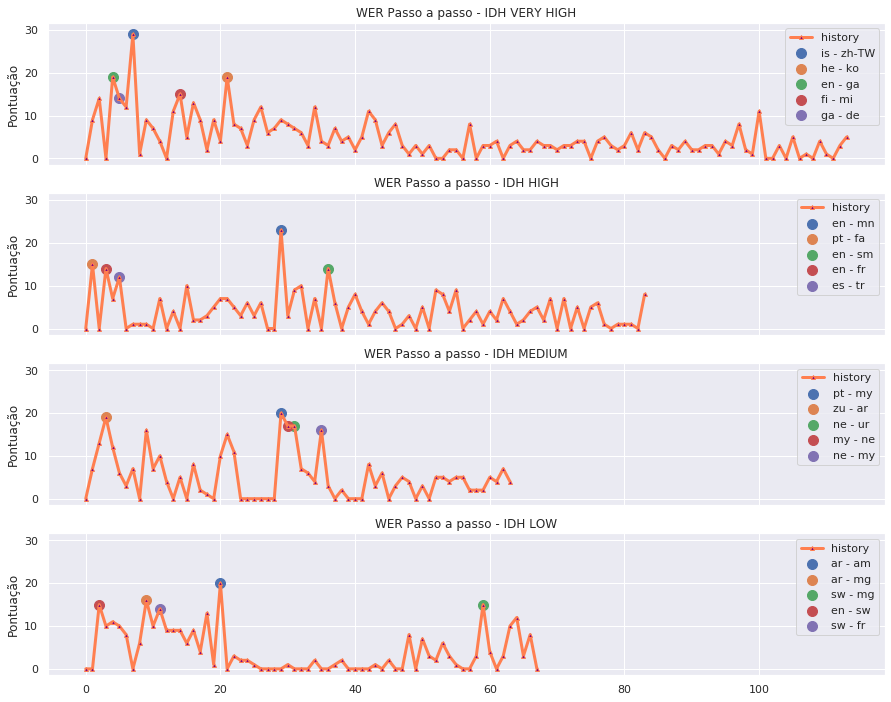

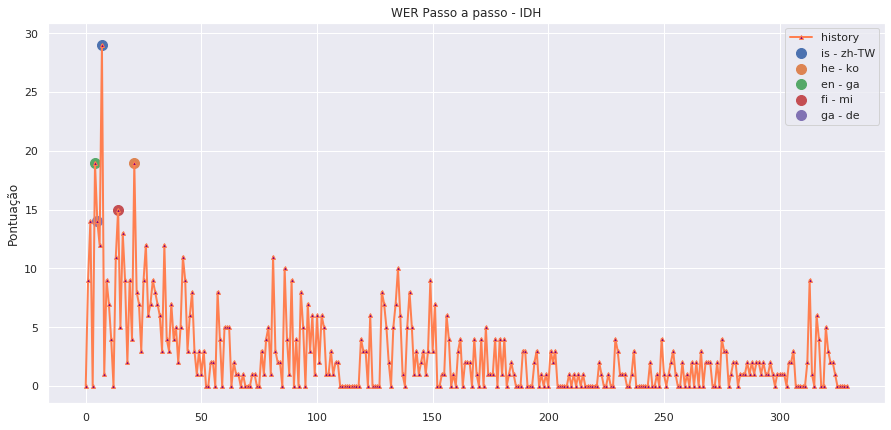

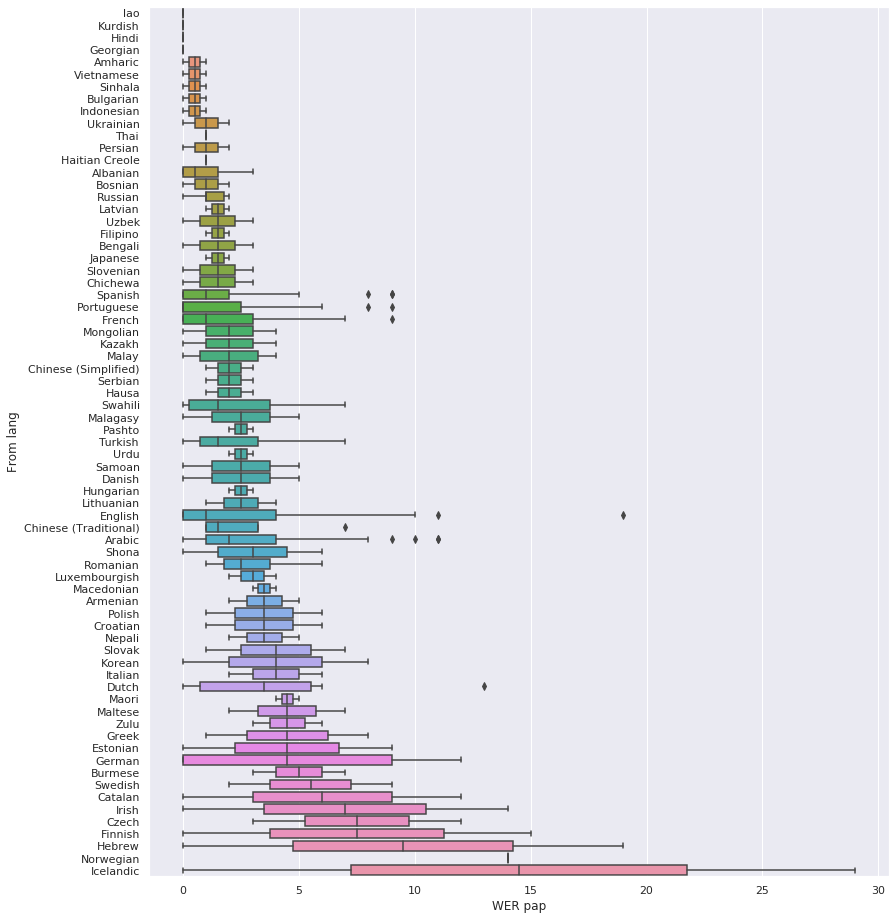

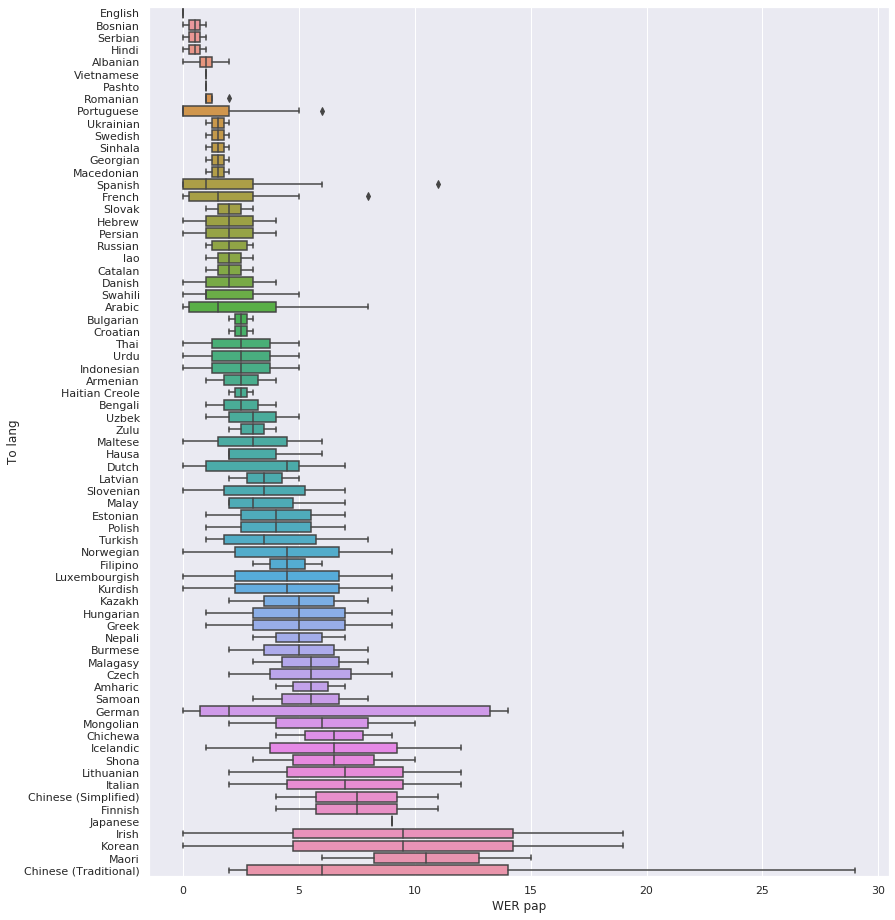

In [74]:
histories = [base_very_high['WER pap'], base_high['WER pap'],
             base_medium['WER pap'], base_low['WER pap']]

f, axs = plt.subplots(4, 1, sharey = True, sharex = True, figsize=(15,12))
plotData4(base_very_high, 'WER Passo a passo - IDH VERY HIGH', axs[0], name = 'WER pap', kind = 'WER')
plotData4(base_high, 'WER Passo a passo - IDH HIGH', axs[1], name = 'WER pap', kind = 'WER')
plotData4(base_medium, 'WER Passo a passo - IDH MEDIUM', axs[2], name = 'WER pap', kind = 'WER')
plotData4(base_low, 'WER Passo a passo - IDH LOW', axs[3], name = 'WER pap', kind = 'WER')

f, ax = plt.subplots(1, 1, sharey = True, sharex = True, figsize=(15,7))
plotData4(base_all, 'WER Passo a passo - IDH', ax, name = 'WER pap', kind = 'WER', linewidth = 2)

plt.figure(figsize=(13.25,16))
sns.set()
ranks = base_all.groupby('From lang')['WER pap'].mean().sort_values(ascending = False)[::-1].index
sns.boxplot(data = base_all, y = 'From lang', x = base_all['WER pap'], order = ranks)
plt.figure(figsize=(13.25,16))
sns.set()
ranks = base_all.groupby('To lang')['WER pap'].mean().sort_values(ascending = False)[::-1].index
sns.boxplot(data = base_all, y = 'To lang', x = base_all['WER pap'], order = ranks)

### Visualização do tamanho do texto

In [75]:
def tamHistory(data):
    size = len(data)
    hist = []
    for i in range(size):
        hist.append(len(data['Text_en'][i].split()))
    return np.asarray(hist)

In [76]:
base_very_high['TAM'] = tamHistory(base_very_high)
base_high['TAM'] = tamHistory(base_high)
base_medium['TAM'] = tamHistory(base_medium)
base_low['TAM'] = tamHistory(base_low)
base_all['TAM'] = tamHistory(base_all)

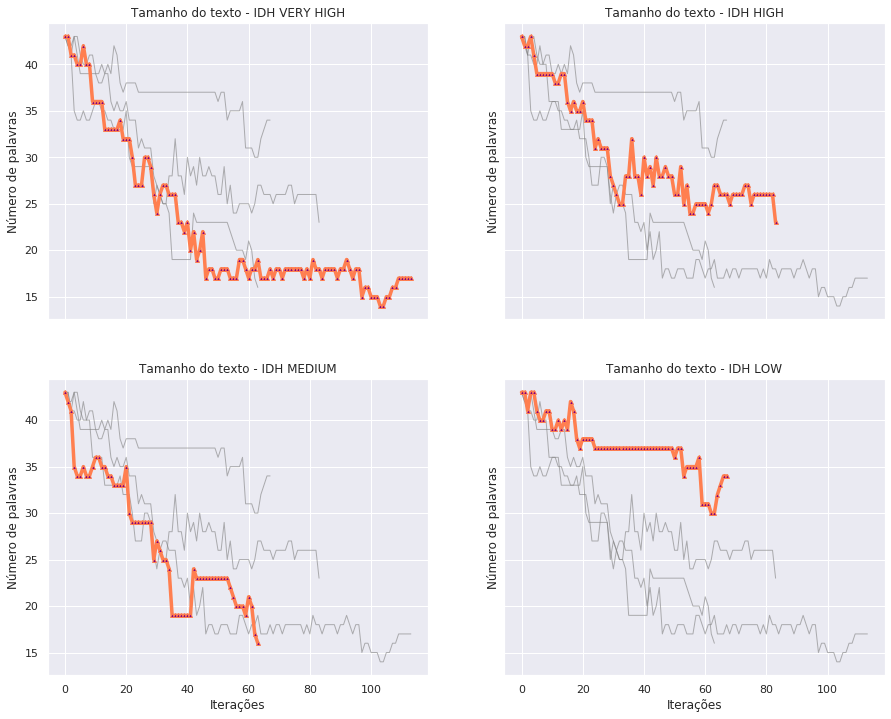

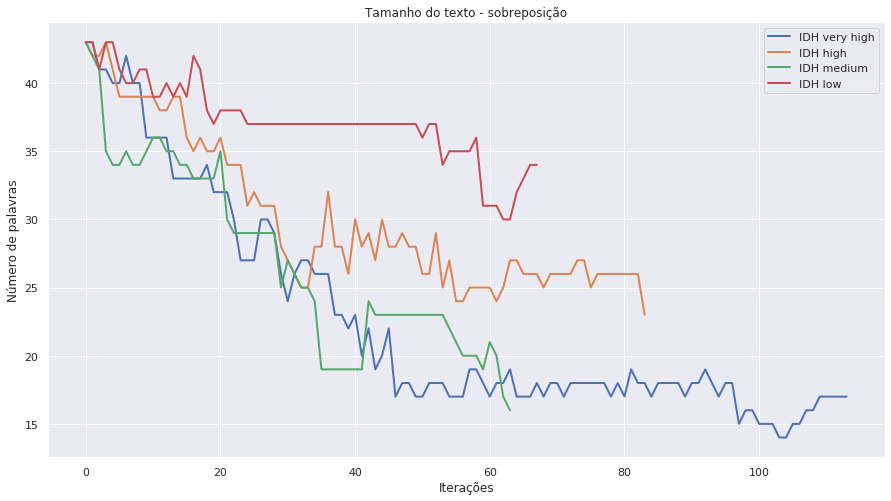

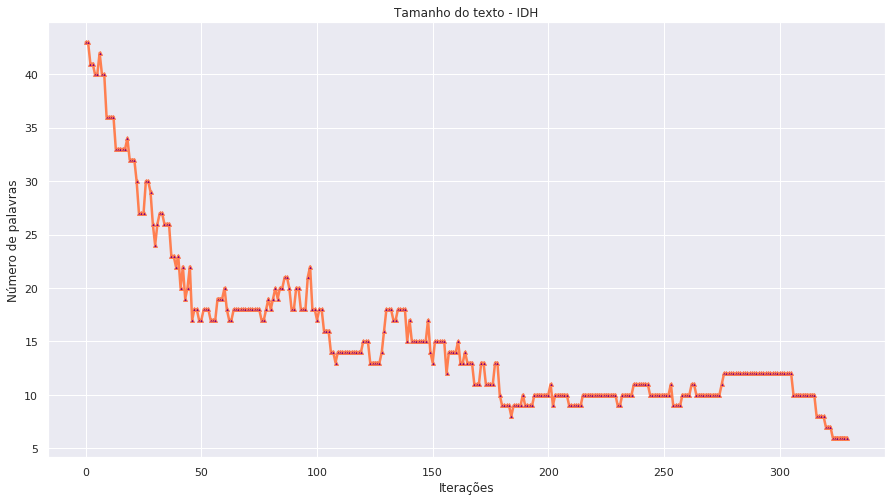

In [77]:
histories = [base_very_high['TAM'], base_high['TAM'],
             base_medium['TAM'], base_low['TAM']]

f, axs = plt.subplots(2, 2, sharey = True, sharex = True, figsize=(15,12))
plotData(base_very_high['TAM'], 'Tamanho do texto - IDH VERY HIGH', axs[0,0],
         xlabel = False, smog_hists = histories, ylabel = 'Número de palavras')
plotData(base_high['TAM'], 'Tamanho do texto - IDH HIGH', axs[0,1],
         xlabel = False, smog_hists = histories, ylabel = 'Número de palavras')
plotData(base_medium['TAM'] , 'Tamanho do texto - IDH MEDIUM', axs[1,0], xlabel = True,
         smog_hists = histories, ylabel = 'Número de palavras')
plotData(base_low['TAM'], 'Tamanho do texto - IDH LOW', axs[1,1], xlabel = True,
         smog_hists = histories, ylabel = 'Número de palavras')

plt.figure(figsize=(15,8))
plotData2(histories, 'Tamanho do texto - sobreposição', ylabel = 'Número de palavras',
          legends = ['IDH very high', 'IDH high', 'IDH medium', 'IDH low'])
plt.figure(figsize=(15,8))
plotData3(base_all['TAM'], 'Tamanho do texto - IDH', ylabel = 'Número de palavras', linewidth = 2.5)